# <p style=" font-size:120%; text-align:center">GAN</p>

<div style=font-size:120%>
Generative Adversarial Networks (GANs) are a powerful class of neural networks that are used for unsupervised learning. It was developed and introduced by Ian J. Goodfellow in 2014. GANs are basically made up of a system of two competing neural network models which compete with each other and are able to analyze, capture and copy the variations within a dataset. 

<div style=font-size:120%>
    
    
A generative adversarial network (GAN) has two parts:

The generator learns to generate plausible data. The generated instances become negative training examples for the discriminator.
The discriminator learns to distinguish the generator's fake data from real data. The discriminator penalizes the generator for producing implausible results.
When training begins, the generator produces obviously fake data, and the discriminator quickly learns to tell that it's fake:
    


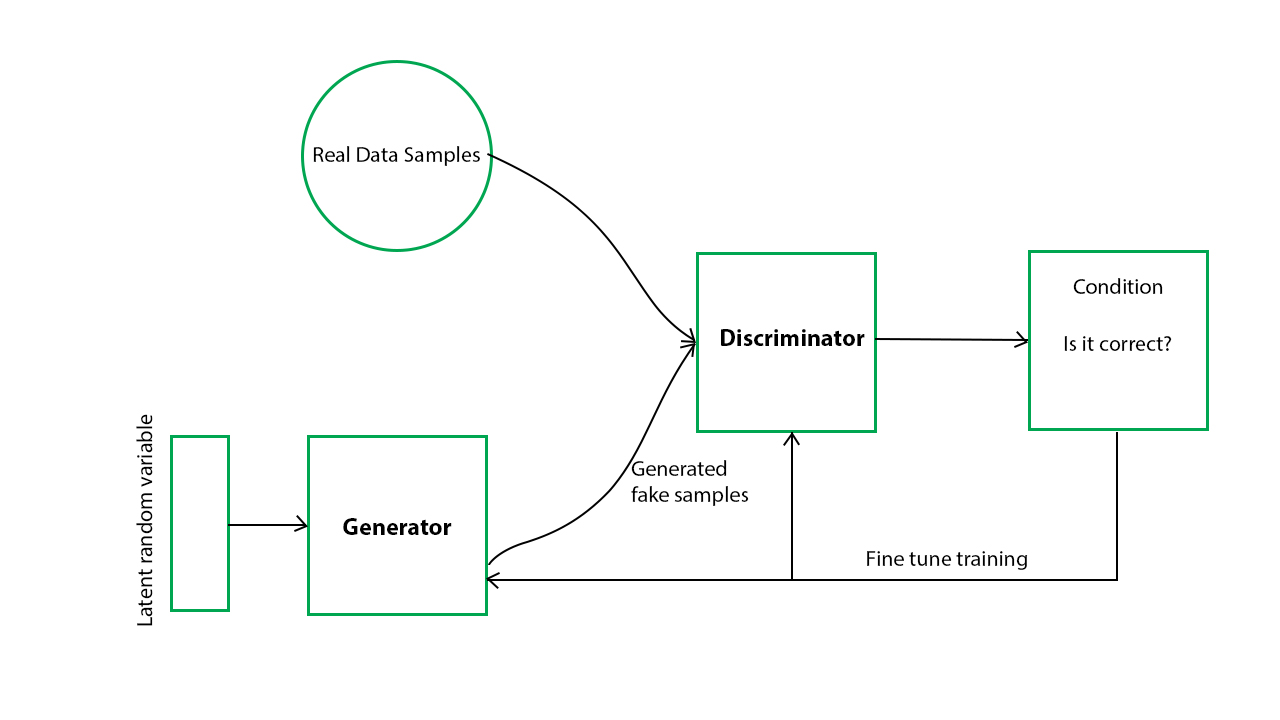

<div style=font-size:120%>

Here, the generative model captures the distribution of data and is trained in such a manner that it tries to maximize the probability of the Discriminator making a mistake. The Discriminator, on the other hand, is based on a model that estimates the probability that the sample that it got is received from the training data and not from the Generator. The GANs are formulated as a minimax game, where the Discriminator is trying to minimize its reward V(D, G) and the Generator is trying to minimize the Discriminator’s reward or in other words, maximize its loss. It can be mathematically described by the formula below: 

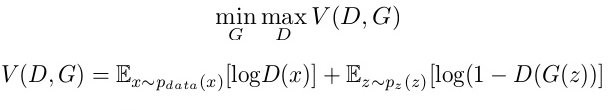

<div style=font-size:120%>

### Generator Model
The Generator is trained while the Discriminator is idle. After the Discriminator is trained by the generated fake data of the Generator, we can get its predictions and use the results for training the Generator and get better from the previous state to try and fool the Discriminator.

### Discriminator Model
The Discriminator is trained while the Generator is idle. In this phase, the network is only forward propagated and no back-propagation is done. The Discriminator is trained on real data for n epochs and sees if it can correctly predict them as real. Also, in this phase, the Discriminator is also trained on the fake generated data from the Generator and see if it can correctly predict them as fake.


<div style=font-size:120%>


### Types Of GAN:

#### Vanilla GAN: 
    This is the simplest type of GAN. Here, the Generator and the Discriminator are simple multi-layer perceptrons. In vanilla GAN, the algorithm is really simple, it tries to optimize the mathematical equation using stochastic gradient descent.
#### Conditional GAN (CGAN): 
    CGAN can be described as a deep learning method in which some conditional parameters are put into place. In CGAN, an additional parameter ‘y’ is added to the Generator for generating the corresponding data. Labels are also put into the input to the Discriminator in order for the Discriminator to help distinguish the real data from the fake generated data.
#### Deep Convolutional GAN (DCGAN): 
    DCGAN is one of the most popular and also the most successful implementations of GAN. It is composed of ConvNets in place of multi-layer perceptrons. The ConvNets are implemented without max pooling, which is in fact replaced by convolutional stride. Also, the layers are not fully connected.
#### Laplacian Pyramid GAN (LAPGAN): 
    The Laplacian pyramid is a linear invertible image representation consisting of a set of band-pass images, spaced an octave apart, plus a low-frequency residual. This approach uses multiple numbers of Generator and Discriminator networks and different levels of the Laplacian Pyramid. This approach is mainly used because it produces very high-quality images. The image is down-sampled at first at each layer of the pyramid and then it is again up-scaled at each layer in a backward pass where the image acquires some noise from the Conditional GAN at these layers until it reaches its original size.
#### Super Resolution GAN (SRGAN): 
    SRGAN as the name suggests is a way of designing a GAN in which a deep neural network is used along with an adversarial network in order to produce higher-resolution images. This type of GAN is particularly useful in optimally up-scaling native low-resolution images to enhance their details minimizing errors while doing so.


<div style=font-size:150%>

    
###                                             I'm going to use DCGAN 


# <p style=" font-size:120%; text-align:center">1-Import Libraries</p>

In [5]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.notebook import tqdm
# Set random seed for reproducibility
manualSeed = 555

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  555


# <p style=" font-size:120%; text-align:center">2-Definition of Hyper Parameters</p>


In [33]:
path = "/kaggle/input/gananime-lite"

workers = 3 # Number of workers
batch_size = 128
image_size = 64
nz = 100 # Size of z latent vector
#เปลี่ยนจำนวนรอบการ train ตรงนี้
num_epochs = 50
lr = 0.001
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers


# <p style=" font-size:120%; text-align:center">3-Import Dataset</p>

In [7]:
#สร้างโรงสร้างสำหรับ dataset โดย data ก็ใ้จาก ด้านขวาเเหละดู part ได้จากด้านบน
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = torchvision.datasets.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

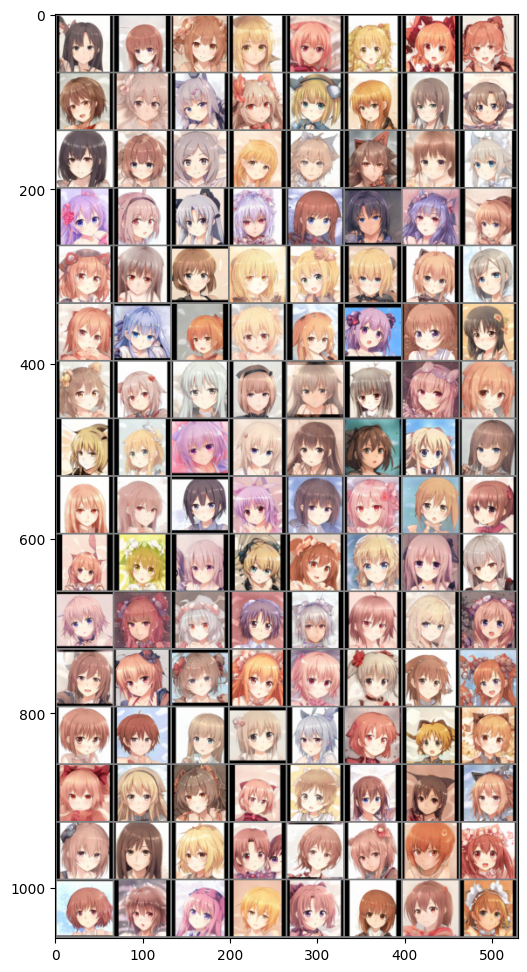

In [9]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloader )
images, labels = next(dataiter)
plt.figure(figsize=(12,12))
# show images
imshow(torchvision.utils.make_grid(images))


# <p style=" font-size:120%; text-align:center">4- Definition of our Model</p>


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #IF WE HAVE GPU WE CAN USE It

# <p style=" font-size:120%; text-align:center">4-1- Discriminator Class</p>

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
            # input is `3x 64 x 64``
        self.conv1=nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.relu1=nn.LeakyReLU(0.2, inplace=True)
            
            # ``64 x 32 x 32``
        self.conv2= nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.btn2=nn.BatchNorm2d(128)
        self.relu2=nn.LeakyReLU(0.2, inplace=True)
            
            # ``128 x 16 x 16``
        self.conv3= nn.Conv2d(128,256, 4, 2, 1, bias=False)
        self.btn3=nn.BatchNorm2d(256)
        self.relu3=nn.LeakyReLU(0.2, inplace=True)
            
            # ``256 x 8 x 8``
        self.conv4= nn.Conv2d(256,512, 4, 2, 1, bias=False)
        self.btn4=nn.BatchNorm2d(512)
        self.relu4=nn.LeakyReLU(0.2, inplace=True)
            
            # 512 x 4 x 4``
        self.conv5= nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        self.sig=nn.Sigmoid()
        

    def forward(self, Input):
        output=self.conv1(Input)
        output=self.relu1(output)
        
        output=self.conv2(output)
        output=self.btn2(output)
        output=self.relu2(output)
        
        output=self.conv3(output)
        output=self.btn3(output)
        output=self.relu3(output)
        
        output=self.conv4(output)
        output=self.btn4(output)
        output=self.relu4(output)
        
        output=self.conv5(output)
        output=self.sig(output)
        
        return output
        

# <p style=" font-size:120%; text-align:center">4-2- Generator Class</p>


In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        

        self.convt1=nn.ConvTranspose2d( 100, 512, 4, 1, 0, bias=False)
        self.btnt1=nn.BatchNorm2d(512)
        self.relut1=nn.ReLU(True)
            
            # ``512*4*4``
        self.convt2=nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
        self.btnt2=nn.BatchNorm2d(256)
        self.relut2=nn.ReLU(True)
            
            # ``256*8*8``
        self.convt3=nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
        self.btnt3=nn.BatchNorm2d(128)
        self.relut3=nn.ReLU(True)
            
            # ``128*16*16``
        self.convt4=nn.ConvTranspose2d(128,64, 4, 2, 1, bias=False)
        self.btnt4=nn.BatchNorm2d(64)
        self.relut4=nn.ReLU(True)
            
            # 64*32*32``
        self.convt5= nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False)
        self.tan=nn.Tanh()
        
     # 3*64*64``
    def forward(self, Input):
        output=self.convt1(Input)
        output=self.btnt1(output)
        output=self.relut1(output)
        
        output=self.convt2(output)
        output=self.btnt2(output)
        output=self.relut2(output)
        
        output=self.convt3(output)
        output=self.btnt3(output)
        output=self.relut3(output)
        
        output=self.convt4(output)
        output=self.btnt4(output)
        output=self.relut4(output)
        
        output=self.convt5(output)
        output=self.tan(output)
        
        return output

# <p style=" font-size:100%; text-align:center">4-3- Weights Initialization </p>


<div style=font-size:120%>

Weight initialization is an important consideration in the design of a neural network model.

The nodes in neural networks are composed of parameters referred to as weights used to calculate a weighted sum of the inputs.

Neural network models are fit using an optimization algorithm called stochastic gradient descent that incrementally changes the network weights to minimize a loss function, hopefully resulting in a set of weights for the mode that is capable of making useful predictions.

This optimization algorithm requires a starting point in the space of possible weight values from which to begin the optimization process. Weight initialization is a procedure to set the weights of a neural network to small random values that define the starting point for the optimization (learning or training) of the neural network model.

In [16]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        


# <p style=" font-size:100%; text-align:center">5-Creating & Training Networks</p>



# <p style=" font-size:100%; text-align:center">5-1-Creating Networks</p>




#### Create the Discriminator

In [17]:

netD = Discriminator().to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda'):
    netD = nn.DataParallel(netD)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)


DataParallel(
  (module): Discriminator(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (sig)

#### Create the generator

In [18]:
        

netG = Generator().to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda'):
    netG = nn.DataParallel(netG)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (convt1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (btnt1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relut1): ReLU(inplace=True)
    (convt2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btnt2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relut2): ReLU(inplace=True)
    (convt3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btnt3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relut3): ReLU(inplace=True)
    (convt4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btnt4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relut4): ReLU(inplace=True)
    (convt5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stri

# <p style=" font-size:100%; text-align:center">5-2-Training Networks</p>


<div style=" font-size:100%; text-align:center">

We will use the Binary Cross Entropy loss (BCELoss) function which is defined in PyTorch as:

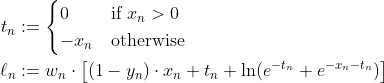

In [19]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

def plot_results():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

<div style=font-size:120%>
##### GANs are very hard to train, as incorrect meta-parameter settings lead to state collapse. But the training of the discriminator network is the same as the normal CNN network.
 
    
##### With training of *Discriminator* we want to maximize \(log(D(x)) + log(1-D(G(z)))\).
    
    
##### And we want to minimize \(log(1-D(G(z)))\) with training of *Generative*.\
    
#### Here we have 4 outputs:
    
##### Loss_D - discriminator loss calculated as the sum of losses for the all real and all fake batches (\(log(D(x)) + log(1 - D(G(z)))\)).

##### Loss_G - generator loss calculated as \(log(D(G(z)))\)

##### D(x) - the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better. Think about why this is.

##### D(G(z)) - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better. Think about why this is.

In [29]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: 
     
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/10][0/201]	Loss_D: 1.0951	Loss_G: 2.8339	D(x): 0.6764	D(G(z)): 0.4332 / 0.0791
[0/10][50/201]	Loss_D: 1.1927	Loss_G: 1.2585	D(x): 0.4295	D(G(z)): 0.1344 / 0.3481
[0/10][100/201]	Loss_D: 1.2480	Loss_G: 1.8394	D(x): 0.5218	D(G(z)): 0.3349 / 0.1885
[0/10][150/201]	Loss_D: 1.0647	Loss_G: 3.4850	D(x): 0.8592	D(G(z)): 0.5574 / 0.0399
[0/10][200/201]	Loss_D: 1.9529	Loss_G: 2.1797	D(x): 0.2015	D(G(z)): 0.0315 / 0.1693
[1/10][0/201]	Loss_D: 1.3294	Loss_G: 2.1012	D(x): 0.7471	D(G(z)): 0.5112 / 0.1579
[1/10][50/201]	Loss_D: 1.1619	Loss_G: 2.1576	D(x): 0.5487	D(G(z)): 0.3527 / 0.1745
[1/10][100/201]	Loss_D: 0.9514	Loss_G: 1.8823	D(x): 0.5835	D(G(z)): 0.2708 / 0.1907
[1/10][150/201]	Loss_D: 1.1499	Loss_G: 2.8420	D(x): 0.7515	D(G(z)): 0.4918 / 0.0764
[1/10][200/201]	Loss_D: 1.0953	Loss_G: 3.3324	D(x): 0.6755	D(G(z)): 0.4617 / 0.0483
[2/10][0/201]	Loss_D: 1.2990	Loss_G: 1.1207	D(x): 0.4311	D(G(z)): 0.2528 / 0.3948
[2/10][50/201]	Loss_D: 1.3726	Loss_G: 1.1239	D(x): 0.3501	D(G(z)): 0.1232 / 0.3816
[

<div style=" font-size:100%; text-align:center">
    

#### We wanna see how D and G’s losses changed during training.



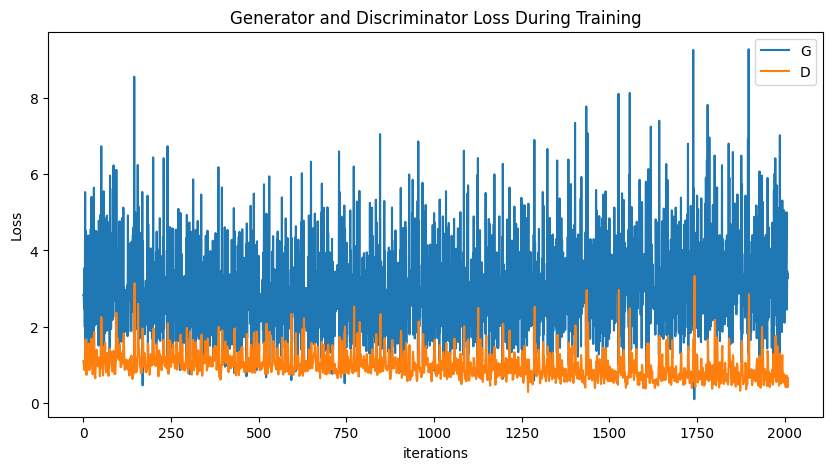

In [30]:
plot_results()
    

<div style=" font-size:100%; text-align:center">
    
    
#### As we have seen, the results during convergent training tended to one side and finally converged

 <center>
<div style=" font-size:100%; text-align:center">
    
<center>
 Best Regards!
    </center>

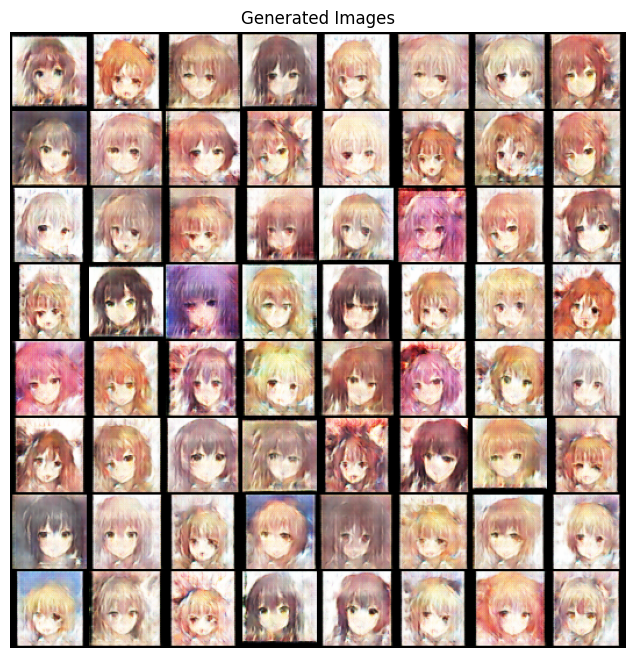

In [31]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# ฟังก์ชันในการแสดงผลภาพ
def show_generated_images(img_list, num_images=64):
    """ แสดงภาพที่สร้างขึ้นจาก Generator """
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    
    # ใช้ `make_grid` เพื่อสร้างกริดจากภาพ
    img_grid = vutils.make_grid(img_list[-1][:num_images], nrow=8, padding=2, normalize=True)
    
    plt.imshow(np.transpose(img_grid.cpu(), (1, 2, 0)))  # เปลี่ยนมิติภาพก่อนแสดง
    plt.show()

# เรียกใช้ฟังก์ชันเพื่อแสดงผล
show_generated_images(img_list)


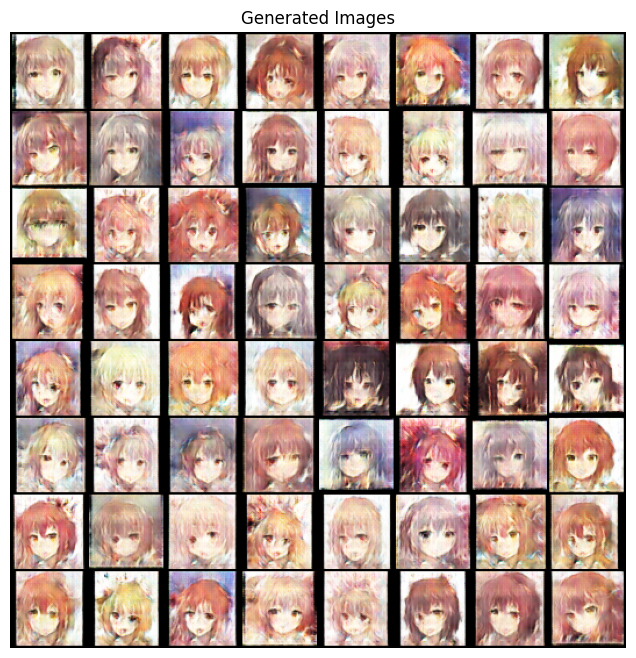

In [32]:
# gen รูปใหม่โดยใช้ model ที่ฝึกมา
# สร้าง latent vector ใหม่
with torch.no_grad():
    noise = torch.randn(64, nz, 1, 1, device=device)  # ขนาด batch_size = 64
    fake_images = netG(noise).detach().cpu()  # ใช้ Generator เพื่อสร้างภาพ

# แสดงผลภาพ
show_generated_images([fake_images])  # เรียกใช้ฟังก์ชันที่เราได้สร้างไว้เพื่อแสดงภาพ
